## Dependencies

In [19]:
import os
import shutil
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Data

In [6]:
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

    
with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
action_categories = sorted(list(set(train_labels)))

In [7]:
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=0, stratify=train_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
val_labels = ['_'.join(name.split('_')[:-1]) for name in val_files]

In [23]:
str_to_int = {"applauding": 0, "climbing": 1, "drinking": 2, "jumping":3 , "pouring_liquid":4, "riding_a_bike":5, "riding_a_horse":6, 
              "running":7, "shooting_an_arrow":8, "smoking":9, "throwing_frisby":10, "waving_hands":11}

y_train = np.array([str_to_int[label] for label in train_labels])
y_val = np.array([str_to_int[label] for label in val_labels])
y_test = np.array([str_to_int[label] for label in test_labels])

In [9]:
x_train = []
for i, file in enumerate(train_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_train.append(img)
x_train = np.asarray(x_train)/255.

In [10]:
x_val = []
for i, file in enumerate(val_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_val.append(img)
x_val = np.asarray(x_val)/255.

In [11]:
x_test = []
for i, file in enumerate(test_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_test.append(img)
x_test = np.asarray(x_test)/255.

## Model

In [12]:
# Baseline from Assignment 4
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(112, 112, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=12, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Confusion matrix

In [24]:
#predicting
def model_prediction(model, x_test, y_test):
    y_prediction = model.predict(x_test) 
    y_prediction = np.argmax (y_prediction, axis = 1)

    #check if true labels and predicted labels have same format
    print('y_test', y_test)
    print('predict:', y_prediction)
    return y_prediction

def cm_cr(y_test, y_prediction):
    #Create confusion matrix and classification report
    cm = confusion_matrix(y_test, y_prediction)
    cr = classification_report(y_test, y_prediction)
    
    print(cm)
    print(cr)
    return cm, cr

def heatmap(cm, title):
    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)
    
    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format   
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers. 
    ax = sns.heatmap(cm, annot=True, fmt = 'd')

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted Actions", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['0: applauding', '1: climbing', '2: drinking', '3: jumping', '4: pouring_liquid', 
                             '5: riding_a_bike', '6: riding_a_horse', '7: running', '8: shooting_an_arrow', '9: smoking',
                            '10: throwing_frisby', '11: waving_hands'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual Actions", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['0: applauding', '1: climbing', '2: drinking', '3: jumping', '4: pouring_liquid', 
                             '5: riding_a_bike', '6: riding_a_horse', '7: running', '8: shooting_an_arrow', '9: smoking',
                            '10: throwing_frisby', '11: waving_hands'])

    # set plot title
    ax.set_title(title, fontsize=14, pad=20)
    
    #rotate labels
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

10/10 [==============================] - 1s 86ms/step
y_test [ 2  8  2  4  0  5  5  5 10 11  3  6  8  3  2  3  6  0  1  8  7  1  4  5
 10  5  0  2  3  9  9  6  5  9 11  0  4  8  1  6  4  1  9 11 10  5  9  6
  3  6 11  6  7  9  6 10  7  4  3  4  5  3  8  1  2  8  1  8  2  1  5  3
  6  0  9  3 11  1 10  2  4  6  9 11  6  1  7  5  0  8 10  1  1  7  7  4
  7  8  0  1  0  5  6 10  1  1  2  7  0  4  6  1  8  6  7  6 11  0  9 11
  5  4 11 11  0  3 10  5  3  2  1  0  5  4  3  3  3  6  2  9  6  0  2  9
 11  7  3  5  3  6  6 11  2  6  1  8  2  5  9  9  3 10  2  7  0  9  5  6
 11  9  2  7  4 10  7  8  9  3  8  7  9 11 10  8  3  6  1  0 10 11  2  0
  6  3  2  7 10 11  1  6  8  7  8  1  5 10  3  3  0  9  4  0  2  4  3  4
  0 10  6  9  0  2  1 10  7  0  9  7  6 11 11  7  2  1  1  5  2  7  5  1
  3  1  3 11  3  5  5  5  8  7  2  7  5  1  0 10  1  5  9  1 10  9  5  6
  3  6  0  1  0  7  5  5  1  4  7  0  3  2  6  5 10  3  8  4  4  2  8  2
  0  0 11  7  4  9  6  8 10  2  3  8  4  0  9 11]
predict: [11 

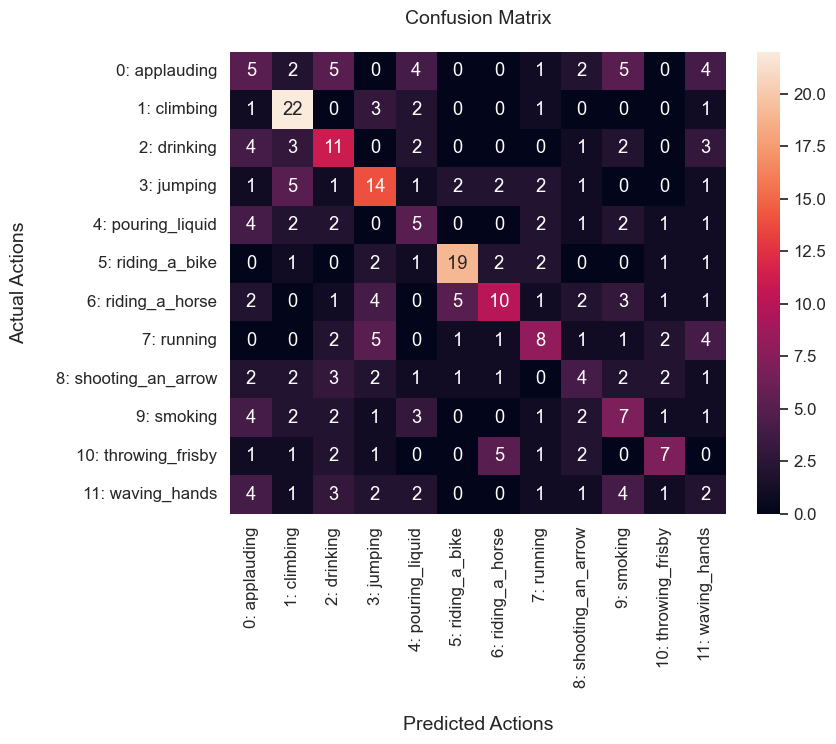

In [26]:
#confusion matrix for Stanford model
y_prediction = model_prediction(model, x_test, y_test)
cm, cr = cm_cr(y_test, y_prediction)
heatmap(cm, "Stanford Confusion Matrix")

## HMDB51 model

In [ ]:
#confusion matrix for HMDB51 model (pasted all this code into the HMDB51 in order to generate
#the matrix, because otherwise we had to import all the data again here)
y_prediction = model_prediction(model, x_test, y_test)
cm, cr = cm_cr(y_test, y_prediction)
heatmap(cm, "Stanford Confusion Matrix")